In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [3]:
class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass
  
  def __len__(self, index):
    return len(self.data_df)

  def __getitem__(self, index):
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label]=1.0

    image_values=torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass

  pass

In [4]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

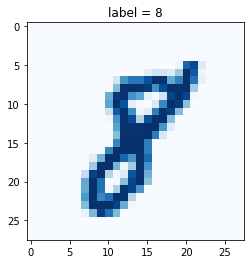

In [5]:
mnist_dataset.plot_image(17)

In [6]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [16]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784+10, 200), #이미지 텐서 784 + 레이블텐서 10
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    self.counter = 0;
    self.progress = []

    pass

  def forward(self, image_tensor, label_tensor):
    inputs = torch.cat((image_tensor, label_tensor))
    return self.model(inputs)

  def train(self, inputs, label_tensor, targets):
    outputs = self.forward(inputs, label_tensor)

    loss = self.loss_function(outputs, targets)

    self.counter += 1;
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass


In [17]:
#임의의 이미지와 함께 임의의 클래스 레이블이 필요-> 임의의 원핫인코딩된 레이블 벡터 만든다
def generate_random_one_hot(size):
  label_tensor = torch.zeros((size))
  random_idx = random.randint(0, size-1)
  label_tensor[random_idx] = 1.0
  return label_tensor

In [20]:
%%time

D=Discriminator()

for label, image_data_tensor, label_tensor in mnist_dataset:
  D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
  D.train(generate_random_image(784), generate_random_one_hot(10), torch.FloatTensor([0.0]))
  pass


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 3min 53s, sys: 3.61 s, total: 3min 57s
Wall time: 3min 57s


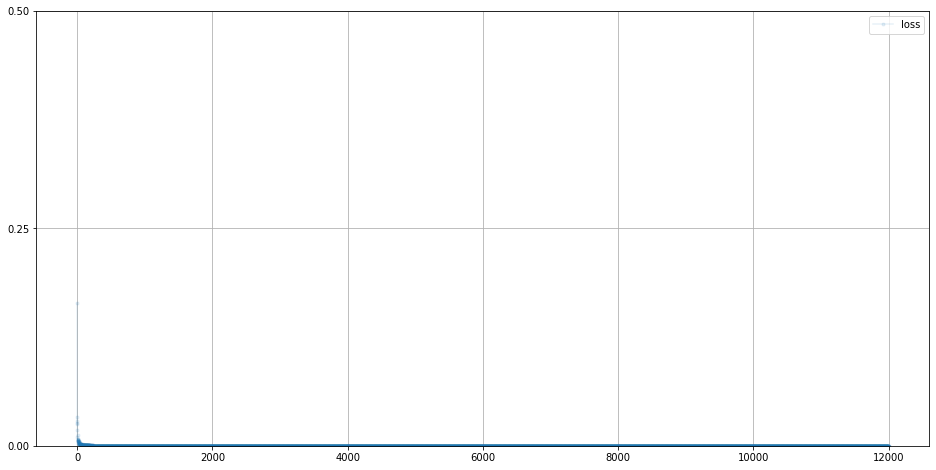

In [21]:
D.plot_progress()

In [23]:
"""
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random_image(784)).item())
  pass
  """

'\nfor i in range(4):\n  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]\n  print(D.forward(image_data_tensor).item())\n  pass\n\nfor i in range(4):\n  print(D.forward(generate_random_image(784)).item())\n  pass\n  '

In [24]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100+10, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    self.optimiser=torch.optim.Adam(self.parameters(), lr=0.0001)

    self.counter=0;
    self.progress=[]

    pass

  def forward(self, seed_tensor, label):
    inputs = torch.cat((seed_tensor, label_tensor))
    return self.model(inputs)

  def train(self, D, inputs,label_tensor, targets):
    g_output = self.forward(inputs, label_tensor)

    d_output = D.forward(g_output, label_tensor)

    loss = D.loss_function(d_output, targets)

    self.counter += 1;
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass

  def plot_images(self, label):
    label_tensor = torch.zeros((10))
    label_tensor[label] = 1.0

    f, axarr = plt.subplots(2, 3, figsize=(16,8))
    for i in range(2):
      for j in range(3):
        axarr[i, j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy(),reshape(28, 28), interpolation='none', cmap='Blues')
        pass
      pass
    pass
  
  pass

In [26]:
"""
G = Generator()

output = G.forward(generate_random_seed(100))

img=output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')
"""

"\nG = Generator()\n\noutput = G.forward(generate_random_seed(100))\n\nimg=output.detach().numpy().reshape(28,28)\n\nplt.imshow(img, interpolation='none', cmap='Blues')\n"

In [30]:
%%time

D = Discriminator()
G=Generator()

epochs = 4

for epoch in range(epochs):
  print("epoch = ", epoch + 1)

  for label, image_data_tensor, target_tensor in mnist_dataset:
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

    random_label = generate_random_one_hot(10)

    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))

    random_label = generate_random_one_hot(10)

    G.train(D, generate_random_seed(100), random_label,torch.FloatTensor([1.0]))

    pass

  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 1h 3min 16s, sys: 29.8 s, total: 1h 3min 46s
Wall time: 1h 3min 39s


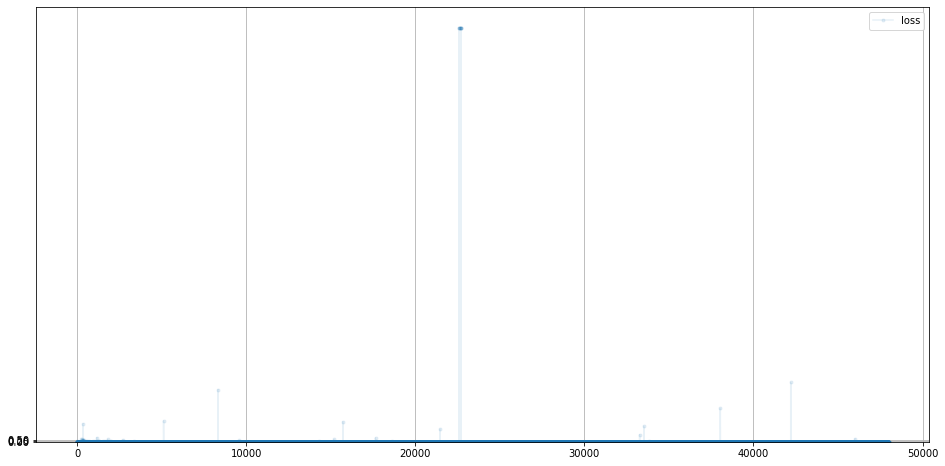

In [31]:
D.plot_progress()

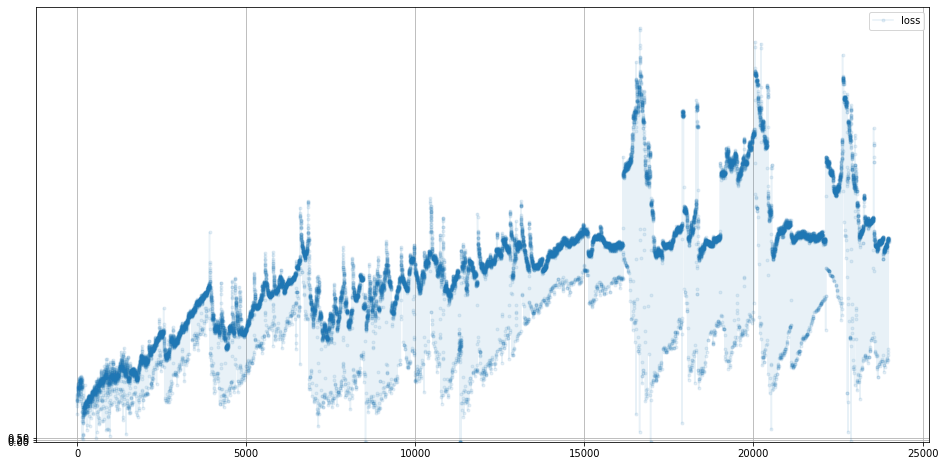

In [32]:
G.plot_progress()

In [ ]:
"""
f, axarr = plt.subplots(2, 3, figsize=(16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28, 28)
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass
  """

NameError: ignored

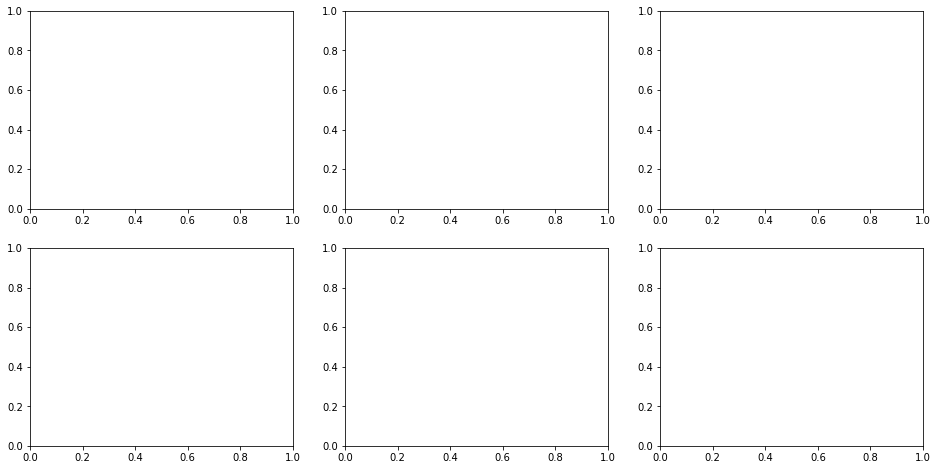

In [33]:
G.plot_images(9)